In [1]:
from astropy.table import Table
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord, Angle
import fact.io as fio
from irf import irf_from_table, EffectiveArea, EnergyDispersion
from regions import CircleSkyRegion
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 6)

/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [12]:
N_MAGIC = ((1.5E-3)/0.001**(-2.58) / (u.TeV * u.cm**2 * u.s)).to(1/(u.TeV * u.km**2 *u.h))
INDEX_MAGIC = -2.58

T_OBS = 17.7
FACT_SCATTER_AREA=(270 *u.m)**2 * np.pi

In [3]:
class PowerLawSpectrumOld():
    
    def __init__(self, index):
        self.index = index

    def draw_samples(self, e_min, e_max, N):
        a = e_min**(self.index + 1)
        b = e_max**(self.index + 1)
        r = np.random.uniform(0, 1, int(N))
        k = (a + (b - a) * r)
        e = k**(1. / (self.index + 1))
        return e

    def counts_in_bins(self, bins, t_obs, area):
        c = np.array([self.counts_in_range(m, n, t_obs, area) for m, n in zip(bins[0:], bins[1:])])
        return c

    def counts_in_range(self, e_low, e_high, t_obs, area):
        index = self.index
        c = (1 / (index + 1)) * (e_high**(index + 1) - e_low**(index + 1))
        return c * t_obs *area

    def event_weights(self, event_energies, e_min, e_max, production_index, t_obs, area=(270 * u.m)**2 * np.pi, total_showers_simulated=10E6):
        gamma = -production_index
        w = event_energies**(gamma) * (e_max**(1 - gamma) - e_min**(1 - gamma)) / (1 - gamma)
        w = w * area * t_obs / total_showers_simulated
        w = w *  event_energies**self.index
        return w   

In [75]:
class PowerLawSpectrum(): 
    
    def __init__(self, index, flux):
        self.index = index
        try:
            self.flux = flux.to(1/(u.TeV * u.m**2 *u.h)).value
        except AttributeError:
            self.flux = flux
            
    @classmethod
    def from_mc_production(cls, production_index, assumed_t_obs, total_showers_simulated, scatter_area, e_min, e_max):
        n = (1 / (production_index + 1)) * (e_max**(production_index + 1) - e_min**(production_index + 1))
        flux = total_showers_simulated / (assumed_t_obs * scatter_area * n)
        return PowerLawSpectrum(production_index, flux)
    
    def __repr__(self):
        return f'PowerLaw Speltrum \n Index:{self.index} \n Flux:{self.flux}'


    def draw_samples(self, e_min, e_max, t_obs, area):
        N = self.counts_in_range(e_min, e_max, t_obs, area)
        a = e_min**(self.index + 1)
        b = e_max**(self.index + 1)
        r = np.random.uniform(0, 1, int(N))
        k = (a + (b - a) * r)
        e = k**(1. / (self.index + 1))
        return e

    def counts_in_bins(self, bins, t_obs, area):
        c = np.array([self.counts_in_range(m, n, t_obs, area) for m, n in zip(bins[0:], bins[1:])])
        return c

    def counts_in_range(self, e_min, e_max, t_obs, area):
        index = self.index
        c = (1 / (index + 1)) * (e_max**(index + 1) - e_min**(index + 1))
        return c * t_obs * area * self.flux

    def event_weights(self, event_energies, e_min, e_max, production_spectrum, t_obs, area):
        gamma = -production_spectrum.index
        total_showers_simulated = production_spectrum.counts_in_range(e_min, e_max, t_obs, area)
        w = event_energies**(gamma) * (e_max**(1 - gamma) - e_min**(1 - gamma)) / (1 - gamma)
        w = w * area * t_obs / total_showers_simulated
        w = w * event_energies**self.index * self.flux
        return w   
    

In [76]:
bins=np.logspace(-0.5, 1.5, 20, base=10)
bin_centers = np.sqrt(bins[0:-1] * bins[1:])

159755.77887957142 253814.16608469267
[0.9648323  0.14865028 0.8608252  ... 0.2607688  0.73987469 0.90110456]


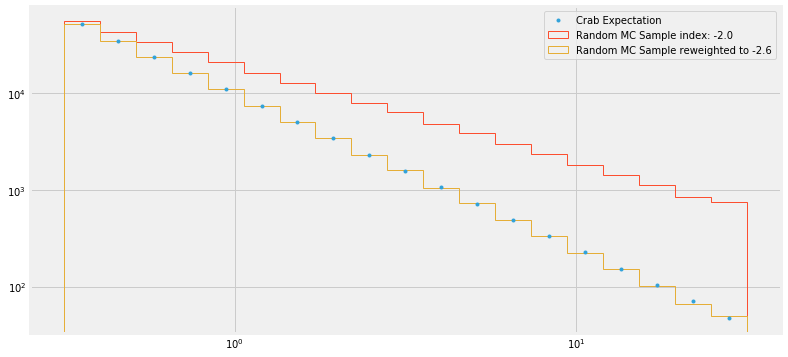

In [77]:

mc_spectrum = PowerLawSpectrum(index=-2.0, flux=0.02)

crab_spectrum = PowerLawSpectrum(index=-2.6, flux=0.01)


N1 = mc_spectrum.counts_in_range(bins.min(), bins.max(), T_OBS, FACT_SCATTER_AREA.value)
N2 = crab_spectrum.counts_in_range(bins.min(), bins.max(), T_OBS, FACT_SCATTER_AREA.value)

print(N2, N1)


mc_energies =  mc_spectrum.draw_samples(bins.min(), bins.max(), t_obs=T_OBS, area=FACT_SCATTER_AREA.value)

crab = crab_spectrum.counts_in_bins(bins, t_obs=T_OBS, area=FACT_SCATTER_AREA.value)

w = crab_spectrum.event_weights(mc_energies, bins.min(), bins.max(), production_spectrum=mc_spectrum, t_obs=T_OBS, area=FACT_SCATTER_AREA.value)
print(w)
plt.plot(bin_centers, crab, '.', label='Crab Expectation')
plt.hist(mc_energies, bins=bins, histtype='step', label=f'Random MC Sample index: {mc_spectrum.index}')
plt.hist(mc_energies, bins=bins, histtype='step', label=f'Random MC Sample reweighted to {crab_spectrum.index}', weights=w)
plt.legend()
plt.xscale('log')
plt.yscale('log')

# print(sum(crab), len(mc_energies))

In [78]:
def generate_fake_data(power_law_model, e_min, e_max, t_obs, area):
    table = Table.read('../fact_irf.fits', hdu='EFFECTIVE AREA')
    grid, data =  irf_from_table(table, interpolation_modes={'ENERG':'log'})
    aeff = EffectiveArea(grid, data)
    
    N = power_law_model.counts_in_range(e_min, e_max, t_obs, area)
    samples = power_law_model.draw_samples(e_min, e_max, t_obs, area)
    trigger_probability = (aeff.evaluate(samples*u.TeV, theta=0*u.deg)/area).si.value
    m  = np.random.uniform(0, 1, size=len(samples)) < trigger_probability
    return samples[m]

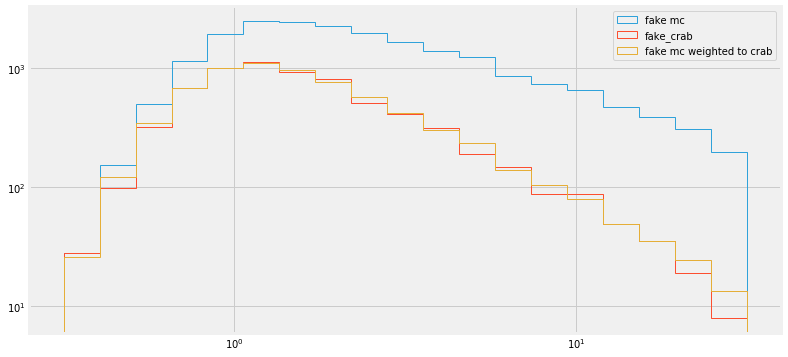

In [79]:
fake_mc = generate_fake_data(mc_spectrum, bins.min(), bins.max(), T_OBS, FACT_SCATTER_AREA.value)
fake_crab = generate_fake_data(crab_spectrum, bins.min(), bins.max(), T_OBS, FACT_SCATTER_AREA.value)

w = crab_spectrum.event_weights(fake_mc, bins.min(), bins.max(), production_spectrum=mc_spectrum, t_obs=T_OBS, area=FACT_SCATTER_AREA.value)

plt.hist(fake_mc, bins=bins, histtype='step', label=f'fake mc')
plt.hist(fake_crab, bins=bins, histtype='step', label=f'fake_crab', )
plt.hist(fake_mc, bins=bins, histtype='step', label=f'fake mc weighted to crab', weights=w)
plt.legend()
plt.xscale('log')
plt.yscale('log')

In [91]:
mc_spectrum = PowerLawSpectrum(index=-2.0, flux=0.01)
N = mc_spectrum.counts_in_range(bins.min(), bins.max(), T_OBS, FACT_SCATTER_AREA.value)
prod = {'production_index': -2.0, 'assumed_t_obs':T_OBS, 'e_max':bins.max(), 'e_min': bins.min(), 'total_showers_simulated' : N, 'scatter_area' : FACT_SCATTER_AREA.value}
mc_spectrum_gen = PowerLawSpectrum.from_mc_production(**prod)

In [92]:
mc_spectrum, mc_spectrum_gen

(PowerLaw Speltrum 
  Index:-2.0 
  Flux:0.01, PowerLaw Speltrum 
  Index:-2.0 
  Flux:0.009999999999999998)